# Python機械学習 勉強会 第十一回「データの表現と特徴量エンジニアリング2」

参考文献：  
Pythonではじめる機械学習　4章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split

<br>

---

## はじめに

今回は以下の内容を取り組む

* 単変量非線形変換
* 自動特徴量選択
* 専門家知識の利用
* まとめと展望

<br>

---

## 4 データの表現と特徴量エンジニアリング
### 4.4 単変量非線形変換

前回、特徴量を2乗、3乗、･･･したものが線形回帰モデルで有用であることを確認した。  
それ以外にも特定の特徴量に有用であることが分かっている変換がある。

それは、log、exp、sinなどの数学関数を用いる方法である。

<br>

線形モデルやニューラルネットワークモデルは、特徴量とターゲットに非線形性があると性能が出にくい。  
特に回帰タスクで堅調に表れる。

log、expなどの関数は、データの相対的なスケールを修正してくれるので、線形モデルやニューラルネットワークモデルでモデリングしやすい。

<br>

あるいは、ほとんどのモデルは個々の特徴量が正規分布に従っているときに、最もよく機能する。  
logやexpによる変化は小手先な技ではあるが、これを実現する簡単で効果的な方法である。

<br>

ここでは、整数のカウントデータ(例：ユーザーが何回ログインしたか、など)を例に、効果を確認してみる。

In [2]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

In [3]:
print("Number of feature appearances:\n{}".format(np.bincount(X[:, 0])))

Number of feature appearances:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


Text(0.5,0,'Value')

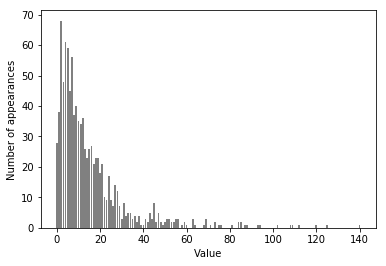

In [4]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='grey')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

このように左側にデータが寄っている分布(感覚とは逆だが右に歪んだ分布と言う)は、カウントデータなどでは非常によく出現する。
* ポワソン分布と言う

しかし、このようなデータは多くの線形モデルではうまく扱えない。  
RIDGE回帰で確認してみる。

In [5]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.622


決定係数$R^2$が比較的小さく、Xとyの関係をうまく捉えられていない。  
しかし、対数(log)変換を行うと話が変わる。

* 注意として、データに0がある場合はlog変換できない(対数は0に対して定義できない)ので、  
    一般的にlog(X+1)変換がよく使われる

In [6]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

Text(0.5,0,'Value')

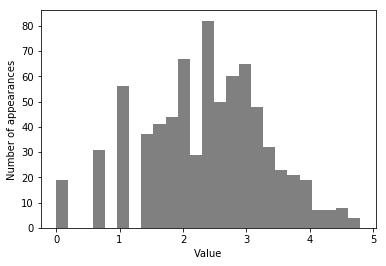

In [7]:
plt.hist(X_train_log[:, 0], bins=25, color='gray')
plt.ylabel("Number of appearances")
plt.xlabel("Value")

log変換後のデータ分散は非対称性が少なく、非常に大きい外れ値もなくなっている。  
このデータに対して再度RIDGEモデルを確認してみる。

In [8]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.875


決定係数$R^2$が飛躍的に向上していることが分かる。

<br>

このようにデータセットと機械学習モデルの組み合わせについて、最適な変換を見つけるのはある種の技が必要になる場合もある。  

この例ではすべての特徴量が同じ特性を持っていたが、現実にはこのような事は少なく、  
一部の特徴量だけ変換したり、特徴量ごとに異なる変換が必要な場合もある。

あるいは、線形回帰モデルにとって、ターゲット変数も変換した方がよい場合も出てくる。

<br>

また、線形モデルについてはこのような変換は有効だが、決定木ベースのモデルには関係ない。
* 決定木ベースのモデルは、自分で重要な交互作用を見つけるから

<br>

SVMや最近傍法、ニューラルネットワークは、ビニングや多項式、交互作用の恩恵を受けることもあるが、  
線形モデルほど顕著ではない。

<br>

---

### 4.5 自動特徴量選択

一般的に特徴量を追加するとモデルは複雑になり、過剰適合(オーバーフィッティング)の可能性が高くなる。  
そこで、高次元なデータセットに対しては、有用な特徴量だけ残して残りは捨てるという方法をとる事がある。

それを実現する3つの方法がある。

* 単変量統計
* モデルベース選択
* 反復選択

これらの手法はすべて「教師あり手法」なので、モデルを適合するためのターゲットが必要。

<br>

#### 4.5.1 単変量統計

単変量統計では、個々の特徴量とターゲット間に統計的な関係があるかどうかを計算し、最も高い確信度で関連している特徴量が選択される。
* クラス分類の場合は、**分散分析(ANOVA)**として知られる手法である。

この方法の特性は**単変量**、すなわち個々の特徴量を個別に考慮する点にある。  
したがって、他の特徴量と組み合わさって意味を持つような特徴量は捨てられてしまう。

<br>

ここで、単変量統計による特徴量選択を、scikit-learnの実装で試してみる。

最も単純な***SelectKBest***では、選択する特徴量の数を指定する。  
一方***SelectPercentile***では、残す特徴量の割合を選択する。

<br>

ここではcancerデータセットを用いて試してみる。

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile

cancer = load_breast_cancer()

# 特徴量抽出の効果を見るためにノイズ特徴量を加える
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# 最初の30個は既存の特徴量、続く50個はノイズ
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

# 50%の特徴量を残す
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


特徴量の数が80個から40個に(50%)減っていることがわかる。  

どの特徴量が使われているかは、***get_support***メソッドで分かる。

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([], <a list of 0 Text yticklabel objects>)

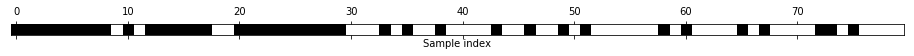

In [10]:
mask = select.get_support()
print(mask)

# マスクを可視化 -- 黒がTrue、白がFalase
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

もとの特徴量はほとんどが選択されており、逆にノイズはほとんど取り除かれている。

試しに、ロジスティック回帰を用いて、全ての特徴量を用いた場合と、選択した特徴量だけを用いた場合とで比較してみる。

In [11]:
from sklearn.linear_model import LogisticRegression

# テストデータの変換
X_test_selected = select.transform(X_test)

lr = LogisticRegression()

lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


この場合、ノイズ特徴量を除去すると、もとの特徴量のいくつかが失われているにも関わらず、性能が向上している。
* すべての特徴量にはノイズが多く含まれているので、そもそも性能が悪化している状態と言える

今回は比較的シンプルな例であり、いつでも性能が向上するわけではない。  
しかし、特徴量が多すぎてモデルを作れないような場合や、多くの特徴量が無駄と思われるような場合には有用である。

<br>

#### 4.5.2 モデルベース特徴量選択

モデルベース特徴量選択は、機械学習モデルを用いて個々の特徴量の重要性を判断し、重要なものだけを残す手法。

* 特徴量選択のために用いる教師あり学習モデルは、最終的に使うモデルと同じでなくても良い。
* 決定木ベースのモデルには、個々の特徴量の重要性を格納している***feature_importances_***属性がある
* 線形モデルには係数があり、絶対値を取れば特徴量の重要性を捉えた値として利用できる

<br>

モデルベースの選択は全ての特徴量を同時に考慮するので(選択に使うモデルが交互作用を捉えられるなら)、  
特徴量間の交互作用も考慮した特徴量選択ができる。

sckit-learnでは***SelectFromModel***を用いることで実現できる。

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

ここでは、100決定木を用いるランダムフォレストを使って、特徴量の重要性を計算し選択する。

In [13]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


([], <a list of 0 Text yticklabel objects>)

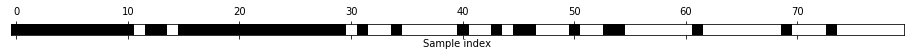

In [14]:
mask = select.get_support()

# マスクを可視化 -- 黒がTrue、白がFalase
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [15]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


単変量統計による特徴量選択と比較し、性能が向上している。

これはランダムフォレストのような複雑なモデルで特徴量の交互作用まで考慮した重要性を計算しており、  
雑に言うならば良い特徴量を残すことができているからと考えられる。

一般的に、単変量統計による特徴量よりもモデルベース特徴量選択の方が強力な手法である。

<br>

#### 4.5.3 反復特徴量選択

反復特徴量選択では、異なる特徴量を用いた一連のモデルを作る。

<br>

基本的には以下2つのやり方がある。
1. 特徴量を使わない状態から、ある基準が満たされるところまで1つずつ特徴量を加える方法
1. 全ての特徴量を使う状態から、1つずつ特徴量を取り除く方法

<br>

この方法の1つが、**再帰的特徴量削減(Recursive Feature Elimination : RFE)**である。

1. 全ての特徴量でモデルを作り、最も重要度の低い特徴量を削除
1. 残りの特徴量でモデルを作り、同じくその中で重要度の低い特徴量を削除
1. 指定の数になるまで繰り返す

<br>

先に用いた方法と同じくランダムフォレストを利用した方法で試してみる。

([], <a list of 0 Text yticklabel objects>)

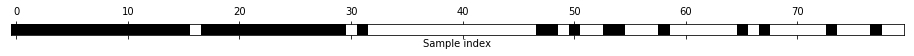

In [16]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)

mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [17]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


今回のような単純なサンプルでは性能が向上していないが、選択されている特徴量を確認すると、先に説明した2つの方法よりも良い特徴量を選択している。
* もとの特徴量を多く残しているため

ただし、RFEは一般的に非常に時間のかかる方法(今回の例では特徴量選択のために40個ほどモデルを作っているため)なので、
使いどころを考慮する必要がある。

<br>

ちなみに、RFEの内部で用いられたモデル(ランダムフォレスト)を用いて予測することも出来る。

In [18]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


今回の例では、適切な特徴量を選ぶことで、線形モデルの性能がランダムフォレストと同じになった。

<br>

機械学習アルゴリズムに対して、どの特徴量を用いればいいか分からない場合は、特徴量の自動選択は有用である。  
また、性能を落とすことなく特徴量の数を減らしたい場合(予測を高速化したい場合など)にも役立つ。

<br>

---

### 4.6 専門家知識の利用

特徴量の自動選択は有効な方法になり得るが、一番強力なのは専門家知識である。  
最初に得られるデータ表現よりもはるかに強力な特徴量を特定、作成することができる場合が多い。

<br>

専門家の知識を利用するケースとして、レンタル自転車の件数予測タスク、  
ある特定の日時にどのくらいの人が自転車をレンタルするか予測することを考えてみる。

まずは、2015年8月のデータをpandasのDataFrameとしてロードし、3時間間隔のデータを眺めてみる。

In [19]:
citibike = mglearn.datasets.load_citibike()

In [20]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0,0.5,'Rentals')

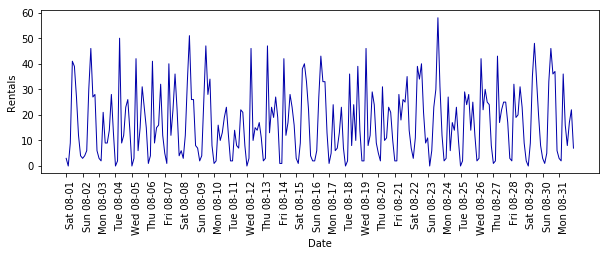

In [21]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

データから、24時間単位の昼間と夜間の区別が明確に見て取れる。  
また週末と平日のパターンも見られる。

このような時系列に対する予測では、**過去から学習し未来を予測する**アプローチをとる。

つまり、ある特定の日までのデータを訓練セットとし、それ以降のデータをテストセットとする手法。
* そうしないと未来の情報を用いて過去を予測するという、現実世界では起こりえない手法で学習してしまう

<br>

このタスクでは、最初の23日分のデータ(184データポイント)を訓練セットとし、残り8日分(64データポイント)をテストセットとした。

このタスクでは、利用できる特徴量は日時だけである。  
上の例では、2015-08-01 00:00:00のような日時が入力され、その後3時間のレンタル数が出力される。

計算機で日時を格納するのによく使われているのがPOSIX時刻である。  
これは、1970年の1月1日0時からの秒数で、Unix時刻とも呼ばれる。

まずは、この特徴量をそのまま使ってみる。

In [22]:
# ターゲット(レンタル数)を抽出
y = citibike.values

# 時刻を"%s"でPOSIX時刻に変換
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [23]:
# データはこんな感じ
citibike.index.astype("int64").values[:5]

array([1438387200000000000, 1438398000000000000, 1438408800000000000,
       1438419600000000000, 1438430400000000000], dtype=int64)

In [24]:
citibike.index.astype("int64").values.reshape(-1, 1)[:5]

array([[1438387200000000000],
       [1438398000000000000],
       [1438408800000000000],
       [1438419600000000000],
       [1438430400000000000]], dtype=int64)

In [25]:
X[:5]

array([[1438387200],
       [1438398000],
       [1438408800],
       [1438419600],
       [1438430400]], dtype=int64)

In [26]:
y[:5]

array([ 3,  0,  9, 41, 39], dtype=int64)

In [27]:
# 最初の184データポイントを訓練に、残りをテストに使う
n_train = 184

In [28]:
# 与えられた特徴量セットでモデルを学習、評価する関数を定義
def eval_on_features(features, target, regressor):
    # 与えられた特徴量を訓練とテストに分割
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    
    # 与えられた学習器を学習
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    # 与えられた学習済学習器で予測
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    # プロットする
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

<br>

POSIX時間を特徴量Xとし、ターゲットであるレンタル数をyとして定義した。

ここではランダムフォレストを試してみる。

Test-set R^2: -0.04


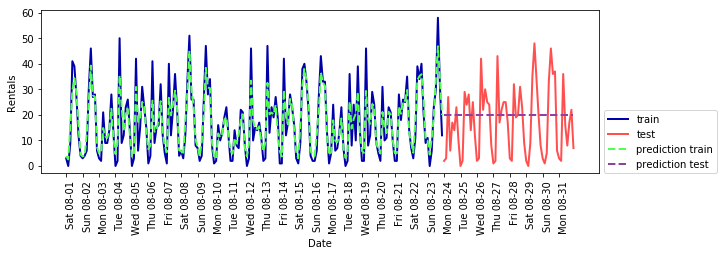

In [29]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

図を見れば分かるが、訓練セットに対しては非常に良い予測行っているが、テストセットに対しては横線になってしまっている。  
$R^2$スコアは-0.04となっており、これは何も学習できていないことを示している。

これは、テストセットのPOSIX時刻の値が、訓練セットのPOSIX時刻のレンジを外れているからである。  
決定木は訓練時のレンジの外にまで外挿できない。

その結果、このモデルは訓練セットの中で最も近い点を予測値としてアウトプットしている。

<br>

ここで、専門家の知識による特徴量エンジニアリングが必要となる。

まず、1日の中の時間帯と曜日が重要であることが分かるので、これらの特徴量を加えてみることにする。  
なお、POSIX時刻を見ても何も分からないので、この特徴量は捨てることにする。

まずは、一日の中の時刻だけを入力してみる。

Test-set R^2: 0.60


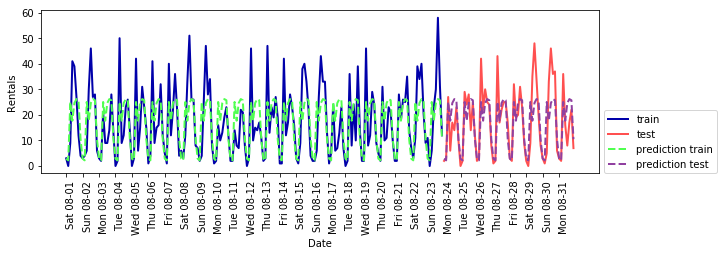

In [30]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

POSIX時刻を入力する場合と比べ、非常に良くなっている。  
$R^2$スコアも0.6と向上している。

次に、曜日情報を加えてみる。

Test-set R^2: 0.84


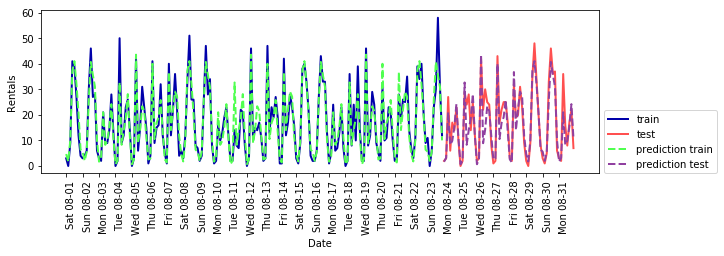

In [31]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

非常に良くなった。$R^2$スコアも0.81と格段に向上している。

このモデルが学習しているのは、8月の最初の23日における、曜日と時刻の組み合わせに対する平均レンタル数である。  

このように、専門家知識(今回の例では常識と言ってもよい)を用いることで、性能を向上させることができる。

<br>

ちなみに、このようなシンプルなデータには複雑なモデルは必要ないので、線形モデルを試してみる。

Test-set R^2: 0.13


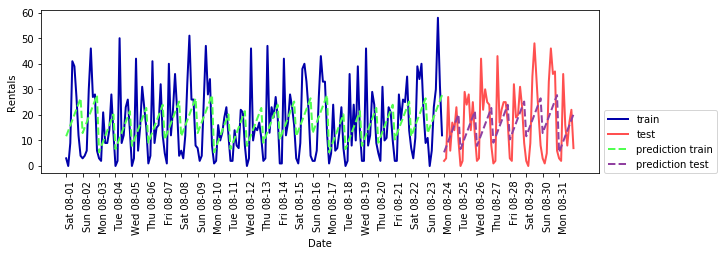

In [32]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

悪化してしまった。
これは、曜日や時刻が整数でエンコードされており、値の大小が考慮される連続値として解釈されているからだ。 

曜日や時刻の情報は数値データではあるがカテゴリ変数に属するため、ここではワンホットエンコーディングを試してみる。

C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Test-set R^2: 0.62


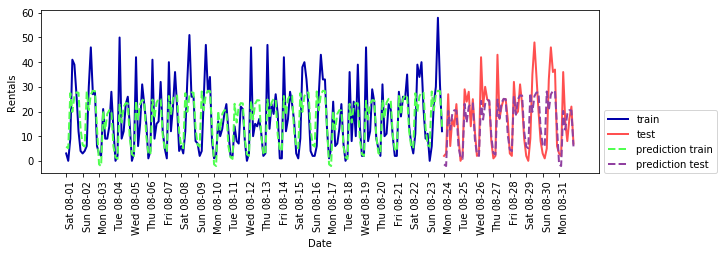

In [33]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, Ridge())

多少はよくなったが、性能は良いとは言えない。

これは、線形モデルは曜日と時刻に対してそれぞれ係数を学習しており、それらの交互作用は考慮できないからだ。
* ランダムフォレストなどの決定木ベースのモデルでは、学習する際に自動的に考慮できている

<br>

そこで、前項で説明した交互作用特徴量を作って試してみる。

Test-set R^2: 0.85


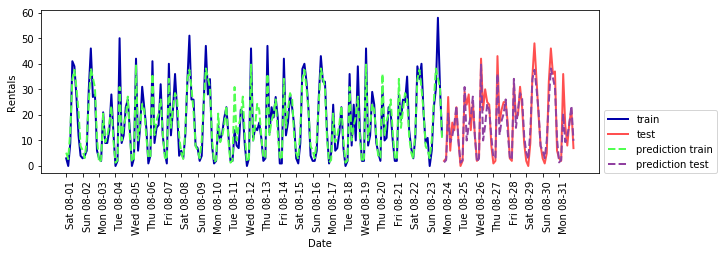

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

lr = Ridge()

eval_on_features(X_hour_week_onehot_poly, y, lr)

これでランダムフォレストと同等以上の性能となった。

<br>

今回わざわざ面倒な特徴量エンジニアリングまでして線形モデルを試したのは、  
線形モデルはランダムフォレストと比較してモデルの解釈が簡単だからである。

各曜日と時刻の組み合わせに対して係数が1つずつ(ランダムフォレストは多数の決定木を用いるので複数ある)であり、
結果の描画も簡単である。

In [35]:
# まず自国と曜日の特徴量に名前を付ける
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

In [36]:
# 抽出した交互作用特徴量に対して名前を付ける
features_poly = poly_transformer.get_feature_names(features)

# また、係数が0でない特徴量だけ残す
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Text(0,0.5,'Feature magnitude')

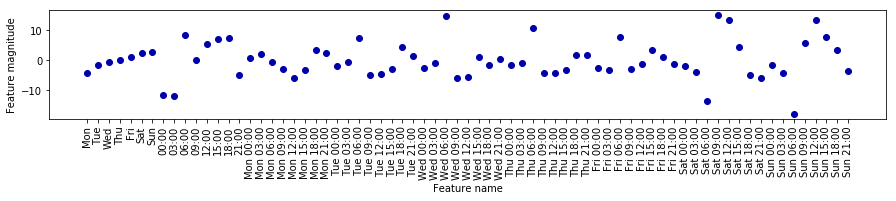

In [37]:
# 可視化
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")

これを見ると、とある曜日と時刻の組み合わせにおいて、レンタルされやすい/されにくいを解釈することができる。

<br>

---

### 4.7 まとめと展望

本章では、主にカテゴリ変数に対するワンホットエンコーディングなど、機械学習モデルに対するデータ表現方法の重要性を学んだ。  
また、新しい特徴量を作ることの重要性や特徴量の自動選択手法なども確認した。

実際に機械学習を応用する際には、どのような特徴量とアルゴリズムを組み合わせるかが、最も重要な要素である。

<br>

次の章では、機械学習モデルの性能評価と正しいパラメータ設定を学んでいく。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。